# Redes Neuronales / Regresión Logística sobre el dataset Titanic
Este notebook construye un modelo de regresión logística entrenado por gradiente descendente,
con interpretación de parámetros, evaluación y visualizaciones. Las variables están escaladas,
y el flujo está diseñado para ser reproducible y robusto frente a reinicios del kernel.

In [4]:
# Imports y configuración
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score)
import joblib
import time

# Opciones visuales
pd.options.display.float_format = '{:.4f}'.format
np.random.seed(42)

In [7]:
# 1) Cargar dataset
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)

# Información rápida
info_df = pd.DataFrame({
    'Info': ['Filas', 'Columnas', 'Valores faltantes'],
    'Valor': [df.shape[0], df.shape[1], int(df.isnull().sum().sum())]
})
display(info_df.style.set_caption("<h2>Información General del Dataset Titanic<h2>").hide(axis='index'))

# Primeras filas
display(df.head(8).style.set_caption("<h2>Primeras 8 filas del Dataset Titanic<h2>"))

Info,Valor
Filas,891
Columnas,12
Valores faltantes,866


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.250000,nan,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.000000,1,0,PC 17599,71.283300,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.925000,nan,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.100000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.050000,nan,S
5,6,0,3,"Moran, Mr. James",male,nan,0,0,330877,8.458300,nan,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,17463,51.862500,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.075000,nan,S


In [9]:
# 2) Preprocesamiento
features = ['Pclass', 'Sex', 'Age', 'Fare', 'SibSp', 'Parch']
target = 'Survived'

# Copia del subconjunto de interés
df_clean = df[features + [target]].copy()

# Manejar valores faltantes: usar asignación para evitar FutureWarning
df_clean['Age'] = df_clean['Age'].fillna(df_clean['Age'].median())
df_clean['Fare'] = df_clean['Fare'].fillna(df_clean['Fare'].median())

# Codificar Sex
le = LabelEncoder()
df_clean['Sex_encoded'] = le.fit_transform(df_clean['Sex'])  # 0: female, 1: male

# Características finales (usar la codificación)
final_features = ['Pclass', 'Sex_encoded', 'Age', 'Fare', 'SibSp', 'Parch']

# Mostrar procesado
display(df_clean[final_features + [target]].head().style.set_caption("<h2>Dataset Procesado para el Modelo<h2>"))

,Pclass,Sex_encoded,Age,Fare,SibSp,Parch,Survived
0,3,1,22.000000,7.250000,1,0,0
1,1,0,38.000000,71.283300,1,0,1
2,3,0,26.000000,7.925000,0,0,1
3,1,0,35.000000,53.100000,1,0,1
4,3,1,35.000000,8.050000,0,0,0


In [12]:
# 3) Análisis exploratorio
stats_descriptivas = df_clean[final_features + [target]].describe()
display(stats_descriptivas.style.set_caption("<h2>Estadísticas Descriptivas<h2>"))

# Distribución objetivo
survived_counts = df_clean[target].value_counts()
survived_pct = df_clean[target].value_counts(normalize=True) * 100
distribucion_df = pd.DataFrame({
    'Supervivencia': ['No Sobrevivió (0)', 'Sobrevivió (1)'],
    'Cantidad': survived_counts.values,
    'Porcentaje (%)': [f"{p:.1f}%" for p in survived_pct.values]
})
display(distribucion_df.style.set_caption("<h2>Distribución de la Variable Objetivo (Survived)<h2>").hide(axis='index'))

# Correlaciones
correlaciones = df_clean[final_features + [target]].corr()[target].sort_values(ascending=False)
corr_df = pd.DataFrame({
    'Característica': correlaciones.index,
    'Correlación con Survived': [f"{val:.3f}" for val in correlaciones.values]
})
display(corr_df.style.set_caption("<h2>Correlaciones con la Supervivencia<h2>").hide(axis='index'))

,Pclass,Sex_encoded,Age,Fare,SibSp,Parch,Survived
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,0.647587,29.361582,32.204208,0.523008,0.381594,0.383838
std,0.836071,0.477990,13.019697,49.693429,1.102743,0.806057,0.486592
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,22.000000,7.910400,0.000000,0.000000,0.000000
50%,3.000000,1.000000,28.000000,14.454200,0.000000,0.000000,0.000000
75%,3.000000,1.000000,35.000000,31.000000,1.000000,0.000000,1.000000
max,3.000000,1.000000,80.000000,512.329200,8.000000,6.000000,1.000000


Supervivencia,Cantidad,Porcentaje (%)
No Sobrevivió (0),549,61.6%
Sobrevivió (1),342,38.4%


Característica,Correlación con Survived
Survived,1.000
Fare,0.257
Parch,0.082
SibSp,-0.035
Age,-0.065
Pclass,-0.338
Sex_encoded,-0.543


In [15]:
# 4) Preparación para el modelo
X = df_clean[final_features].values.astype(float)
y = df_clean[target].values.astype(int)

# Forma / tipos
dimensiones_df = pd.DataFrame({
    'Dataset': ['Características (X)', 'Target (y)'],
    'Forma': [str(X.shape), str(y.shape)],
    'Tipo': [f"{X.dtype}", f"{y.dtype}"]
})
display(dimensiones_df.style.set_caption("<h2>Dimensiones de los Datos<h2>").hide(axis='index'))

# División train/test (estratificada)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Escalado (MinMax)
scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

resumen_preprocesamiento = pd.DataFrame({
    'Paso': ['Datos originales', 'Después de limpieza', 'Train split', 'Test split'],
    'Filas': [len(df), len(df_clean), len(X_train), len(X_test)],
    'Características': [len(features), len(final_features), X_train.shape[1], X_test.shape[1]]
})
display(resumen_preprocesamiento.style.set_caption("<h2>Resumen del Preprocesamiento<h2>").hide(axis='index'))

Dataset,Forma,Tipo
Características (X),"(891, 6)",float64
Target (y),"(891,)",int64


Paso,Filas,Características
Datos originales,891,6
Después de limpieza,891,6
Train split,623,6
Test split,268,6


In [16]:
# 5) Funciones auxiliares
def sigmoide(z):
    z = np.clip(z, -50, 50)  # estabilidad numérica
    return 1.0 / (1.0 + np.exp(-z))

def prob(W, x, b):
    return sigmoide(np.dot(W, x) + b)

def pred_binaria(W, x, b, thr=0.5):
    return 1 if prob(W, x, b) >= thr else 0

In [17]:
# 6) Entrenamiento por gradiente descendente (regresión logística)
def entrenar_logistica_hist(X, y, lr=0.1, epocas=2000, paciencia=200, seed=42, verbose=False):
    rng = np.random.default_rng(seed)
    W = rng.uniform(-0.01, 0.01, size=X.shape[1])
    b = 0.0
    n = len(X)
    eps = 1e-12

    best_loss = np.inf
    best_W, best_b = W.copy(), float(b)
    sin_mejora = 0
    loss_hist = []

    t0 = time.time()
    for epoch in range(1, epocas+1):
        scores = X @ W + b
        p = sigmoide(scores)

        # pérdida log-loss
        loss = -np.mean(y * np.log(np.clip(p, eps, 1-eps)) + (1-y) * np.log(np.clip(1-p, eps, 1-eps)))
        loss_hist.append(float(loss))

        # gradientes
        grad = (p - y)
        dW = (X.T @ grad) / n
        db = np.mean(grad)

        # actualización
        W -= lr * dW
        b -= lr * db

        # early stopping simple
        if loss < best_loss - 1e-8:
            best_loss = loss
            best_W, best_b = W.copy(), float(b)
            sin_mejora = 0
        else:
            sin_mejora += 1
            if sin_mejora >= paciencia:
                if verbose:
                    print(f"Early stopping en epoch {epoch} (sin mejora {sin_mejora} it.)")
                break

        if verbose and (epoch % 200 == 0 or epoch == 1):
            print(f"Epoch {epoch:4d} - Loss: {loss:.6f}")

    t1 = time.time()
    if verbose:
        print(f"Entrenamiento completado en {epoch} epochs, tiempo {t1-t0:.2f}s, best_loss={best_loss:.6f}")
    return best_W, best_b, loss_hist

In [18]:
# Ejecutar entrenamiento (ajusta lr/epocas según preferencia)
W, b, loss_hist = entrenar_logistica_hist(X_train_sc, y_train, lr=0.5, epocas=5000, paciencia=600, seed=42, verbose=True)
print("W shape:", W.shape, "b:", round(b, 6))

Epoch    1 - Loss: 0.693974
Epoch  200 - Loss: 0.463564
Epoch  400 - Loss: 0.453807
Epoch  600 - Loss: 0.448869
Epoch  800 - Loss: 0.445859
Epoch 1000 - Loss: 0.443945
Epoch 1200 - Loss: 0.442690
Epoch 1400 - Loss: 0.441844
Epoch 1600 - Loss: 0.441259
Epoch 1800 - Loss: 0.440846
Epoch 2000 - Loss: 0.440548
Epoch 2200 - Loss: 0.440329
Epoch 2400 - Loss: 0.440166
Epoch 2600 - Loss: 0.440042
Epoch 2800 - Loss: 0.439948
Epoch 3000 - Loss: 0.439875
Epoch 3200 - Loss: 0.439818
Epoch 3400 - Loss: 0.439773
Epoch 3600 - Loss: 0.439738
Epoch 3800 - Loss: 0.439710
Epoch 4000 - Loss: 0.439688
Epoch 4200 - Loss: 0.439670
Epoch 4400 - Loss: 0.439655
Epoch 4600 - Loss: 0.439644
Epoch 4800 - Loss: 0.439634
Epoch 5000 - Loss: 0.439627
Entrenamiento completado en 5000 epochs, tiempo 0.51s, best_loss=0.439627
W shape: (6,) b: 3.929742


In [19]:
# Comprobar existencia de W/b y entrenar si es necesario
if 'W' not in globals() or 'b' not in globals():
    print("W o b no definidos. Entrenando modelo ahora...")
    W, b, loss_hist = entrenar_logistica_hist(X_train_sc, y_train, lr=0.5, epocas=5000, paciencia=600, seed=42, verbose=True)
    print("Entrenamiento finalizado.")
else:
    print("W y b ya definidos. Continuando...")

W y b ya definidos. Continuando...


In [27]:
# 7) Interpretación de parámetros
parametros_df = pd.DataFrame({
    'Característica': final_features + ['Intercepto (bias)'],
    'Parámetro (Peso)': [f"{w:.4f}" for w in W] + [f"{b:.4f}"],
    'Notas': [
        "Pclass (escalada): 1=Primera, 3=Tercera (recordar: variable escalada)",
        "Sex_encoded (0=female,1=male) - codificado y escalado",
        "Age (años) - escalado",
        "Fare (precio) - escalado",
        "SibSp - escalado",
        "Parch - escalado",
        "Término independiente (bias)"
    ]
})
display(parametros_df.style.set_caption("<h2>Parámetros del Modelo (aplican sobre características escaladas)<h2>").hide(axis='index'))

# Importancia
importancia_absoluta = np.abs(W)
impacto = ["POSITIVO" if w > 0 else "NEGATIVO" for w in W]
importancia_df = pd.DataFrame({
    'Característica': final_features,
    'Importancia Absoluta (|W|)': [f"{imp:.4f}" for imp in importancia_absoluta],
    'Impacto en Supervivencia (signo de W)': impacto,
    'Explicación simple (sobre escalado)': [
        f"Si la versión escalada de {feat} aumenta, la probabilidad {'aumenta' if W[idx] > 0 else 'disminuye'}"
        for idx, feat in enumerate(final_features)
    ]
})
display(importancia_df.style.set_caption("<h2>Análisis de Importancia de Características (W en datos escalados)<h2>").hide(axis='index'))

Característica,Parámetro (Peso),Notas
Pclass,-2.1794,"Pclass (escalada): 1=Primera, 3=Tercera (recordar: variable escalada)"
Sex_encoded,-2.7571,"Sex_encoded (0=female,1=male) - codificado y escalado"
Age,-3.3912,Age (años) - escalado
Fare,1.3936,Fare (precio) - escalado
SibSp,-2.5274,SibSp - escalado
Parch,-0.5764,Parch - escalado
Intercepto (bias),3.9297,Término independiente (bias)


Característica,Importancia Absoluta (|W|),Impacto en Supervivencia (signo de W),Explicación simple (sobre escalado)
Pclass,2.1794,NEGATIVO,"Si la versión escalada de Pclass aumenta, la probabilidad disminuye"
Sex_encoded,2.7571,NEGATIVO,"Si la versión escalada de Sex_encoded aumenta, la probabilidad disminuye"
Age,3.3912,NEGATIVO,"Si la versión escalada de Age aumenta, la probabilidad disminuye"
Fare,1.3936,POSITIVO,"Si la versión escalada de Fare aumenta, la probabilidad aumenta"
SibSp,2.5274,NEGATIVO,"Si la versión escalada de SibSp aumenta, la probabilidad disminuye"
Parch,0.5764,NEGATIVO,"Si la versión escalada de Parch aumenta, la probabilidad disminuye"


In [26]:
# 8) Evaluación
probs_train = sigmoide(X_train_sc @ W + b)
probs_test = sigmoide(X_test_sc @ W + b)
y_pred_train = (probs_train >= 0.5).astype(int)
y_pred_test = (probs_test >= 0.5).astype(int)

acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test, zero_division=0)
rec_test = recall_score(y_test, y_pred_test, zero_division=0)
f1_test = f1_score(y_test, y_pred_test, zero_division=0)
auc_test = roc_auc_score(y_test, probs_test)

metricas_comparativas = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'],
    'Train': [f"{acc_train:.3f}", "-", "-", "-", "-"],
    'Test': [f"{acc_test:.3f}", f"{prec_test:.3f}", f"{rec_test:.3f}", f"{f1_test:.3f}", f"{auc_test:.3f}"]
})
display(metricas_comparativas.style.set_caption("<h2>Métricas de Evaluación del Modelo<h2>").hide(axis='index'))

cm = confusion_matrix(y_test, y_pred_test)
cm_df = pd.DataFrame(cm, 
                     index=['Real: No Sobrevivió', 'Real: Sobrevivió'], 
                     columns=['Pred: No Sobrevivió', 'Pred: Sobrevivió'])
display(cm_df.style.set_caption("<h2>Matriz de Confusión - Dataset de Test<h2>").hide(axis='index'))

# Reporte
print("Classification report (test):\n", classification_report(y_test, y_pred_test, digits=4))

Métrica,Train,Test
Accuracy,0.793,0.799
Precision,-,0.738
Recall,-,0.738
F1-Score,-,0.738
AUC-ROC,-,0.850


Pred: No Sobrevivió,Pred: Sobrevivió
138,27
27,76


Classification report (test):
               precision    recall  f1-score   support

           0     0.8364    0.8364    0.8364       165
           1     0.7379    0.7379    0.7379       103

    accuracy                         0.7985       268
   macro avg     0.7871    0.7871    0.7871       268
weighted avg     0.7985    0.7985    0.7985       268



In [30]:
# 8) Evaluación
probs_train = sigmoide(X_train_sc @ W + b)
probs_test = sigmoide(X_test_sc @ W + b)
y_pred_train = (probs_train >= 0.5).astype(int)
y_pred_test = (probs_test >= 0.5).astype(int)

acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test, zero_division=0)
rec_test = recall_score(y_test, y_pred_test, zero_division=0)
f1_test = f1_score(y_test, y_pred_test, zero_division=0)
auc_test = roc_auc_score(y_test, probs_test)

metricas_comparativas = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'],
    'Train': [f"{acc_train:.3f}", "-", "-", "-", "-"],
    'Test': [f"{acc_test:.3f}", f"{prec_test:.3f}", f"{rec_test:.3f}", f"{f1_test:.3f}", f"{auc_test:.3f}"]
})
display(metricas_comparativas.style.set_caption("<h2>Métricas de Evaluación del Modelo<h2>").hide(axis='index'))

cm = confusion_matrix(y_test, y_pred_test)
cm_df = pd.DataFrame(cm, 
                     index=['Real: No Sobrevivió', 'Real: Sobrevivió'], 
                     columns=['Pred: No Sobrevivió', 'Pred: Sobrevivió'])
display(cm_df.style.set_caption("<h2>Matriz de Confusión - Dataset de Test<h2>").hide(axis='index'))

# Reporte
print("Classification report (test):\n", classification_report(y_test, y_pred_test, digits=4))

Métrica,Train,Test
Accuracy,0.793,0.799
Precision,-,0.738
Recall,-,0.738
F1-Score,-,0.738
AUC-ROC,-,0.850


Pred: No Sobrevivió,Pred: Sobrevivió
138,27
27,76


Classification report (test):
               precision    recall  f1-score   support

           0     0.8364    0.8364    0.8364       165
           1     0.7379    0.7379    0.7379       103

    accuracy                         0.7985       268
   macro avg     0.7871    0.7871    0.7871       268
weighted avg     0.7985    0.7985    0.7985       268



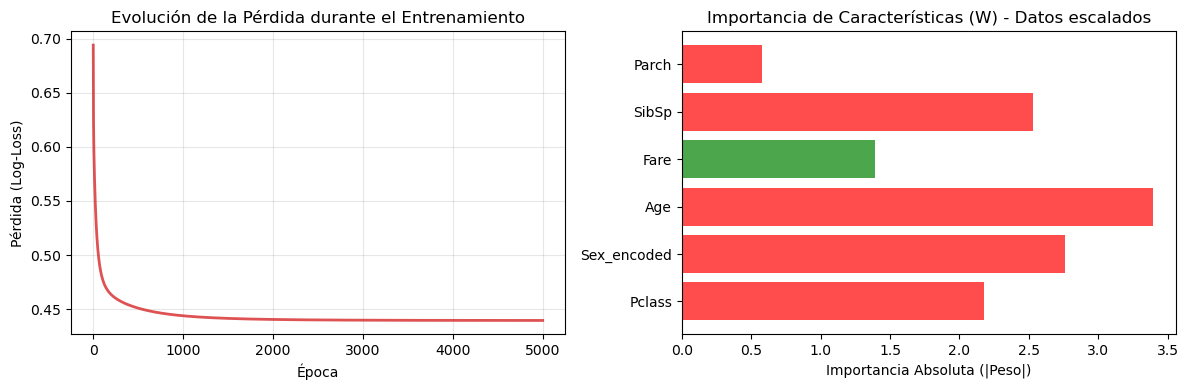

In [31]:
# 9) Visualizaciones
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(loss_hist, linewidth=2, color='tab:red', alpha=0.8)
plt.xlabel("Época")
plt.ylabel("Pérdida (Log-Loss)")
plt.title("Evolución de la Pérdida durante el Entrenamiento")
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
colors = ['green' if w > 0 else 'red' for w in W]
plt.barh(final_features, importancia_absoluta, color=colors, alpha=0.7)
plt.xlabel("Importancia Absoluta (|Peso|)")
plt.title("Importancia de Características (W) - Datos escalados")
plt.tight_layout()
plt.show()

In [36]:
# 10) Predicciones ejemplo e interpretación por contribuciones
casos_ejemplo = [
    [1, 0, 25, 100, 0, 0],  # Mujer joven 1ra clase, sola
    [3, 1, 35, 20, 2, 3],   # Hombre adulto 3ra clase, con familia
    [2, 0, 60, 50, 1, 0],   # Mujer mayor 2da clase, con esposo
]

resultados_interpretacion = []
for i, caso in enumerate(casos_ejemplo):
    caso_sc = scaler.transform([caso]).ravel()
    probabilidad = sigmoide(W @ caso_sc + b)
    prediccion = int(probabilidad >= 0.5)
    contribuciones = W * caso_sc
    contribucion_total = contribuciones.sum() + b

    resultados_interpretacion.append({
        'Caso': f"Ejemplo {i+1}",
        'Descripción': [
            "Mujer joven en 1ra clase",
            "Hombre adulto en 3ra clase con familia", 
            "Mujer mayor en 2da clase"
        ][i],
        'Probabilidad': f"{probabilidad:.3f}",
        'Predicción': "Sobrevive" if prediccion == 1 else "No sobrevive",
        'Contribución_total (logit)': f"{contribucion_total:.4f}"
    })

resultados_df = pd.DataFrame(resultados_interpretacion)
display(resultados_df.style.set_caption("<h2>Predicciones para Casos de Ejemplo<h2>").hide(axis='index'))

# Detalle del primer caso
caso_detalle = casos_ejemplo[0]
caso_detalle_sc = scaler.transform([caso_detalle]).ravel()
prob_detalle = sigmoide(W @ caso_detalle_sc + b)
analisis_detallado = pd.DataFrame({
    'Característica': final_features + ['Intercepto'],
    'Valor Original': caso_detalle + [1],
    'Valor Escalado': [f"{v:.3f}" for v in caso_detalle_sc] + ["-"],
    'Peso (W)': [f"{w:.4f}" for w in W] + [f"{b:.4f}"],
    'Contribución (W * x_scaled)': [f"{c:.4f}" for c in (W * caso_detalle_sc)] + [f"{b:.4f}"]
})
display(analisis_detallado.style.set_caption("<h2>Análisis Detallado de Contribuciones - Caso Ejemplo 1<h2>").hide(axis='index'))

Caso,Descripción,Probabilidad,Predicción,Contribución_total (logit)
Ejemplo 1,Mujer joven en 1ra clase,0.959,Sobrevive,3.1543
Ejemplo 2,Hombre adulto en 3ra clase con familia,0.034,No sobrevive,-3.3460
Ejemplo 3,Mujer mayor en 2da clase,0.530,Sobrevive,0.1212


Característica,Valor Original,Valor Escalado,Peso (W),Contribución (W * x_scaled)
Pclass,1,0.000,-2.1794,-0.0000
Sex_encoded,0,0.000,-2.7571,-0.0000
Age,25,0.309,-3.3912,-1.0474
Fare,100,0.195,1.3936,0.2720
SibSp,0,0.000,-2.5274,-0.0000
Parch,0,0.000,-0.5764,-0.0000
Intercepto,1,-,3.9297,3.9297


In [38]:
# 11) Guardar modelos/recursos
joblib.dump(scaler, "scaler_titanic.joblib")
joblib.dump(le, "label_encoder_sex.joblib")
np.savez("logistica_titanic.npz", W=W, b=b)

feature_info = {
    'feature_names': final_features,
    'feature_descriptions': [
        "Clase del pasaje (1 = Primera, 2 = Segunda, 3 = Tercera)",
        "Sexo (0 = Femenino, 1 = Masculino)",
        "Edad en años",
        "Precio del boleto",
        "Número de hermanos/esposos a bordo",
        "Número de padres/hijos a bordo"
    ]
}
joblib.dump(feature_info, "feature_info_titanic.joblib")

archivos_guardados = pd.DataFrame({
    'Archivo': [
        'scaler_titanic.joblib',
        'label_encoder_sex.joblib', 
        'logistica_titanic.npz',
        'feature_info_titanic.joblib'
    ],
    'Propósito': [
        'Escalador para nuevas características',
        'Codificador de variable Sex',
        'Pesos y parámetros del modelo',
        'Información para interpretación'
    ]
})
display(archivos_guardados.style.set_caption("<h2>Archivos del Modelo Guardados<h2>").hide(axis='index'))

Archivo,Propósito
scaler_titanic.joblib,Escalador para nuevas características
label_encoder_sex.joblib,Codificador de variable Sex
logistica_titanic.npz,Pesos y parámetros del modelo
feature_info_titanic.joblib,Información para interpretación
